In [1]:
import json
import os
from os import listdir
from os.path import isfile, join
import pickle
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import tabulate
import numpy as np
import math

import re

from itertools import cycle, islice

# Fitting Linear Regression to the dataset 
from sklearn.linear_model import LinearRegression 
# Fitting Polynomial Regression to the dataset 
from sklearn.preprocessing import PolynomialFeatures 

from scipy.stats import pearsonr

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [2]:
fig_width = 8
fig_height = 5

params = {
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    #'text.fontsize': 8, # was 10
    'legend.fontsize': 12, # was 10
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': True,
    'text.usetex': False,
    'figure.figsize': [fig_width,fig_height],
    'font.family': 'serif',
    'grid.linestyle': '--',
    'lines.linewidth': 2
}

matplotlib.rcParams.update(params)

In [93]:
data_dir = join('..', 'data', 'dataset_data')
exp_log_dir = join('..', 'data', 'aggregated_data-incremental_exp_cikm')
out_dir = join('..', 'plots', 'statistical_analysis')


appname = 'LUBM'
data_size_dir = 'LUBM'
collections = ['schemex', 'attribute', 'type']
suffix = ''
hide_legend = False


appname = 'BSBM'
data_size_dir = 'BSBM'
collections =['schemex', 'attribute', 'type']
suffix = ''
hide_legend = True

appname = 'dyldo_y2019_core'
data_size_dir = 'DyLDO-core'
collections =['schemex', 'attribute', 'type']
suffix = '-test-1_clean'
hide_legend = True

appname = 'dyldo_y2019_full'
data_size_dir = 'DyLDO-ext'
collections =['schemex', 'attribute', 'type']
suffix = ''
hide_legend = True

drop the beat


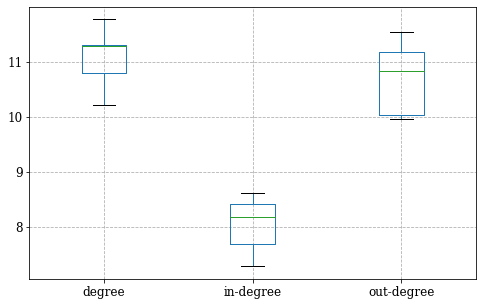

In [94]:
curr_dir = join(data_dir, data_size_dir)
onlyfiles = [f for f in listdir(curr_dir) if isfile(join(curr_dir, f)) and f.endswith(".csv")]
onlyfiles.sort(key=natural_keys)

degree_frame = pd.DataFrame()
i = 0
for filename in onlyfiles:
    with open(os.path.join(curr_dir, filename), 'r') as f:
        df = pd.read_csv(f, sep=',')
        if 'iteration' in filename:
            iteration = filename.replace('iteration', '')
            iteration = iteration.replace('-', '')
            iteration = iteration.replace('degree.csv', '')
            iteration = iteration.replace('.gz', '')
            iteration = iteration.replace('.nq', '')
            iteration = iteration.replace('.nt', '')
            i = int(iteration)
        else:
            i = i + 1

        df['Iteration'] = i
        df = df.set_index('Iteration')
        if degree_frame.empty:
            degree_frame = df
        else:
            degree_frame = degree_frame.append(df)

#plot = degree_frame['max_degree'].plot()  
if appname == 'dyldo_y2019_core':
    degree_frame = degree_frame.drop(degree_frame.index[[21,22]])


if appname == 'dyldo_y2019_full':
    degree_frame = degree_frame.head()
    iterations = 5
    ticks = 1.0
    print('drop the beat')

    
#ax.set_ylabel("")

plot_frame = degree_frame[['avg_degree', 'avg_indegree', 'avg_outdegree']]

plot_frame.columns = ['degree', 'in-degree', 'out-degree']

boxplot = plot_frame.boxplot() 

plt.savefig(out_dir + '/' + data_size_dir + '-degree.pdf', bbox_inches = 'tight')
plt.savefig(out_dir + '/' + data_size_dir + '-degree.png', bbox_inches = 'tight')

In [9]:
display(degree_frame['avg_degree'].mean())
display(degree_frame['avg_degree'].std())

display(degree_frame['avg_indegree'].mean())
display(degree_frame['avg_indegree'].std())

display(degree_frame['avg_outdegree'].mean())
display(degree_frame['avg_outdegree'].std())

6.722038056412259

0.001951984633295234

6.837695954224687

0.0015297443529795666

5.091578619618349

0.0037573414483207525

In [26]:
# The main correlation analysis

appnames = ['BSBM', 'dyldo_y2019_core', 'dyldo_y2019_full']
appnames = ['dyldo_y2019_core']

datasets = ['LUBM', 'BSBM', 'DyLDO-core', 'DyLDO-ext']
datasets = ['DyLDO-core']

models = ['schemex', 'attribute', 'type']
#models = ['attribute']


size_frame = pd.DataFrame(columns=['dataset', 'edges', 'types', 'bytes'])

index = 0
for dataset in datasets:
    curr_dir = join(data_dir, dataset)
    onlyfiles = [f for f in listdir(curr_dir) if isfile(join(curr_dir, f)) and f.endswith(".txt")]
    onlyfiles.sort(key=natural_keys)


    temp_frame = pd.DataFrame(columns=['dataset', 'edges', 'types', 'bytes', 'degree'])
    i = 0
    for filename in onlyfiles:
        f = open(join(curr_dir,filename), 'r')
        f_degree = open(join(curr_dir,filename.replace(".txt", "-degree.csv")), 'r')
        content = f.read().split('\n')

        df = pd.read_csv(f_degree, sep=',')
        df['Iteration'] = i
        df = df.set_index('Iteration')

        types = int(content[0])
        edges = int(content[1])
        bytez = int(content[2])
        degree = df['avg_degree'].values[0]

        if 'iteration' in filename:
            iteration = filename.replace('iteration', '')
            iteration = iteration.replace('-', '')
            iteration = iteration.replace('.txt', '')
            iteration = iteration.replace('.gz', '')
            iteration = iteration.replace('.nq', '')
            iteration = iteration.replace('.nt', '')
            i = int(iteration)
        else:
            i = i + 1
        temp_frame.loc[i] = [dataset, edges, types, bytez, degree]
        

    
    for model in models:
        f_space = open(os.path.join(exp_log_dir, appnames[index] + '_'+model+'-update-time-and-space.csv'), 'r')
        #print(f_space)
        sf = pd.read_csv(f_space, sep=',')
        sf = sf.set_index('Iteration')
        #display(sf)
        temp_frame[model+'-summarization-ratio'] = sf['Imprint links'] / sf['Schema Elements (SE)']
        temp_frame[model+'VHI'] = sf['Sec. Index Size (bytes)']
        temp_frame[model+'-compression'] = temp_frame[model+'VHI'] / temp_frame['bytes']
        if 'instances' not in temp_frame:
            temp_frame['instances'] = sf['Imprint links']
        f_time = open(os.path.join(exp_log_dir, appnames[index] + '_'+model+'-performance.csv'), 'r')
        #print(f_time)
        tf = pd.read_csv(f_time, sep=',')
        tf = tf.set_index('Iteration')
        #display(tf)
        temp_frame[model+'schema-computation'] = tf['Schema Computation']
        temp_frame[model+'update'] = tf['Updates']
        temp_frame[model+'incremental'] = tf['Total']
        temp_frame[model+'batch'] = tf['Batch']
        temp_frame[model+'speed-up'] = tf['Batch'] / tf['Total']

        
        f_change = open(os.path.join(exp_log_dir, appnames[index] + '_'+model+'-changes.csv'), 'r')
        cf = pd.read_csv(f_change, sep=',')
        temp_frame[model+':changes'] = cf['ChangedSchemaStructures (SE_mod)'] +  ((sf['Imprint links'] - sf['Imprint links'].shift(1,fill_value=0)).abs())
        temp_frame[model+':updates'] = cf['NewlyObservedSchema (SE_new)'] + cf['DeletedSchemaStructures (SE_del)']
        temp_frame[model+':change-update-ratio'] = temp_frame[model+':changes']/(temp_frame[model+':updates'] + 1)
        #attribute:changes
        temp_frame[model+':change-size-ratio'] = temp_frame[model+':changes']/(temp_frame['instances'])
        temp_frame[model+':update-size-ratio'] = temp_frame[model+':updates']/(sf['Schema Elements (SE)'])

    if dataset == 'DyLDO-core':
        temp_frame = temp_frame.drop(temp_frame.index[[20,21]])
    if dataset == 'DyLDO-ext':
        temp_frame = temp_frame.head(5)
        
    if size_frame.empty:
        size_frame = temp_frame
    else:
        size_frame = size_frame.append(temp_frame)
        
  
    index = index + 1
#speedup for last row does not make sense
size_frame.dropna(inplace=True)

size_frame.to_csv(out_dir + '/' + 'correlation-stats.csv', sep=',', encoding='utf-8')

display(size_frame.head())
for model in models:
    print("Summarization Ratio ({}): ".format(model))
    print("\tMean:\t {}".format(size_frame[model+'-summarization-ratio'].mean()))
    print("\tStd:\t {}".format(size_frame[model+'-summarization-ratio'].std()))
    print("\tMin:\t {}".format(size_frame[model+'-summarization-ratio'].min()))
    print("\tMAX:\t {}".format(size_frame[model+'-summarization-ratio'].max()))

    print("Change-Update Ratio ({}): ".format(model))
    print("\tMean:\t {}".format(size_frame[model+':change-update-ratio'].mean()))
    print("\tStd:\t {}".format(size_frame[model+':change-update-ratio'].std()))
    print("\tMin:\t {}".format(size_frame[model+':change-update-ratio'].min()))
    print("\tMAX:\t {}".format(size_frame[model+':change-update-ratio'].max()))
    
    print("Incremental Time ({}): ".format(model))
    print("\tMean:\t {}".format(size_frame[model+'incremental'].mean()))
    print("\tStd:\t {}".format(size_frame[model+'incremental'].std()))
    print("\tMin:\t {}".format(size_frame[model+'incremental'].min()))
    print("\tMAX:\t {}".format(size_frame[model+'incremental'].max()))
    
    print("Batch Time ({}): ".format(model))
    print("\tMean:\t {}".format(size_frame[model+'batch'].mean()))
    print("\tStd:\t {}".format(size_frame[model+'batch'].std()))
    print("\tMin:\t {}".format(size_frame[model+'batch'].min()))
    print("\tMAX:\t {}".format(size_frame[model+'batch'].max()))
    
    print("Speed-up Time ({}): ".format(model))
    print("\tMean:\t {}".format(size_frame[model+'speed-up'].mean()))
    print("\tStd:\t {}".format(size_frame[model+'speed-up'].std()))
    print("\tMin:\t {}".format(size_frame[model+'speed-up'].min()))
    print("\tMAX:\t {}".format(size_frame[model+'speed-up'].max()))
    print("-----------")

    
#display(size_frame)
print('schemex')
display(size_frame['attribute-compression'])
print(size_frame['schemex-compression'].mean())
print(size_frame['schemex-compression'].std())

print('attribute')
print(size_frame['attribute-compression'].mean())
print(size_frame['attribute-compression'].std())

print('type')
print(size_frame['type-compression'].mean())
print(size_frame['type-compression'].std())

,dataset,edges,types,bytes,degree,schemex-summarization-ratio,schemexVHI,schemex-compression,instances,schemexschema-computation,...,typeschema-computation,typeupdate,typeincremental,typebatch,typespeed-up,type:changes,type:updates,type:change-update-ratio,type:change-size-ratio,type:update-size-ratio
1,DyLDO-core,10707414,0,170365210,3.536531,27.988602,100724015.0,0.591224,3228961.0,48639.0,...,49297.0,190417.0,1288757.0,8621541.0,6.689811,207929.0,155.0,1332.878205,0.064395,0.025739
2,DyLDO-core,10340958,0,163484782,3.554121,30.296065,116500643.0,0.712608,3507224.0,54855.0,...,51385.0,237902.0,1569300.0,9946542.0,6.338203,278904.0,133.0,2081.373134,0.079523,0.022031
3,DyLDO-core,12663496,0,192083558,3.977475,30.268823,115343913.0,0.600488,2328520.0,53190.0,...,77285.0,230224.0,1636788.0,10307263.0,6.297250,15014.0,45.0,326.391304,0.006448,0.007465
4,DyLDO-core,12375527,0,188678908,3.992746,29.911181,112629520.0,0.596938,2300439.0,52193.0,...,75540.0,205692.0,1436288.0,9338966.0,6.502154,91352.0,56.0,1602.666667,0.039711,0.009278
5,DyLDO-core,10615535,0,166929845,3.495737,27.995284,102549656.5,0.614328,2148834.0,55607.0,...,53457.0,224351.0,1523698.0,8291073.0,5.441415,227975.0,136.0,1664.051095,0.106092,0.022546


Summarization Ratio (schemex): 
	Mean:	 24.123601602947986
	Std:	 4.445600814737506
	Min:	 18.387952127659574
	MAX:	 30.299723756906076
Change-Update Ratio (schemex): 
	Mean:	 153.75749207075248
	Std:	 363.67377638576363
	Min:	 3.456093868281605
	MAX:	 2519.2781316348196
Incremental Time (schemex): 
	Mean:	 1341001.5208333333
	Std:	 315949.8131222735
	Min:	 982238.0
	MAX:	 2625815.0
Batch Time (schemex): 
	Mean:	 3193779.9583333335
	Std:	 263416.8439362979
	Min:	 2778763.0
	MAX:	 3805106.0
Speed-up Time (schemex): 
	Mean:	 2.4595838889558084
	Std:	 0.3572072298241573
	Min:	 1.2545758174128794
	MAX:	 2.9622230816076853
-----------
Summarization Ratio (attribute): 
	Mean:	 141.86542959425836
	Std:	 25.47049047588546
	Min:	 104.05656379548596
	MAX:	 178.21290619251994
Change-Update Ratio (attribute): 
	Mean:	 313.2954015875126
	Std:	 320.13009489697487
	Min:	 3.1671168129642133
	MAX:	 1328.190361445783
Incremental Time (attribute): 
	Mean:	 1267430.8541666667
	Std:	 251633.65945772175
	Mi

1     0.573785
2     0.691305
3     0.582233
4     0.581219
5     0.594634
6     0.606775
7     0.583311
8     0.662511
9     0.520314
10    0.743826
11    0.524454
12     0.70168
13    0.587658
14     0.48417
15    0.722886
16    0.577048
17    0.654615
18    0.657282
19     0.59358
20    0.687204
23    0.788549
24    0.628256
25    0.607882
26    0.556764
27    0.601849
28    0.591995
29    0.584222
30    0.607321
31    0.607165
32    0.598553
33    0.577329
34     0.58894
35    0.595685
36    0.594101
37    0.549054
38    0.567783
39    0.685519
40    0.619604
41    0.620578
42    0.559194
43    0.825654
44    0.511911
45    0.598087
46    0.967684
47    0.541321
48    0.621221
49    0.602994
50    0.599312
Name: attribute-compression, dtype: object

0.643720442419716
0.08871268886864024
attribute
0.6193545247309794
0.08414167553109353
type
0.5979684094142745
0.07921739808149166


In [95]:
def scatter_plot_regression(df, x_value, y_value):
    print("Is there a linear correlation between '%s' and '%s'?" % (x_value, y_value))
    corrtest = pearsonr(df[x_value], df[y_value]) 
    print("Pearson Coefficient of %.3f (p = %.6f)" % (round(corrtest[0], 3), round(corrtest[1], 6)))    
    
    X = df[x_value].to_numpy() # , 'change-ratio'
    y = df[y_value].values
    #display(X)
    # make matrix
    X = X.reshape(-1, 1) 
    lin = LinearRegression() 

    print(X.shape)
    print(y.shape)
    lin.fit(X, y) 
    print("Linear Regression Coefficient of %.3f" % round(lin.coef_[0], 3))
    # Visualising the Linear Regression results 
    plt.scatter(X, y, color = 'blue') 
    #plt.scatter(b, y, color = 'green') 

    plt.plot(X, lin.predict(X), color = 'red') 
    plt.title('Linear Regression') 
    plt.xlabel(x_value) 
    plt.ylabel(y_value) 

    lin.score(X, y)
    plt.savefig(out_dir + '/' + x_value + '-vs-' + y_value + '.pdf', bbox_inches = 'tight')
    plt.savefig(out_dir + '/' + x_value + '-vs-' + y_value + '.png', bbox_inches = 'tight')
    plt.show() 

Is there a linear correlation between 'edges' and 'attributeschema-computation'?
Pearson Coefficient of 0.503 (p = 0.000272)
(48, 1)
(48,)
Linear Regression Coefficient of 0.002


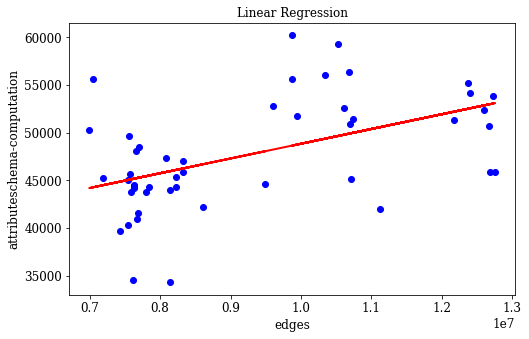

In [96]:
x_values = ['attribute:change-size-ratio'] #'change-ratio'
x_values = ['attribute:update-size-ratio'] #'change-ratio'
x_values = ['edges']


y_value = ['attributespeed-up']
y_value = ['attributeschema-computation']

x_value = 'edges'
y_value = 'attributeschema-computation'
scatter_plot_regression(size_frame, x_value, y_value)



In [97]:
#tmp = size_frame[['edges', 'schemexschema-computation', 'attributeschema-computation', 'typeschema-computation']]
# display(tmp.head())
# display(tmp.astype('float64').corr())

"""
Build a frame for all three summary models:
"""

full_frame = pd.DataFrame(columns=['vertices', 'edges', 'vertexHashIndex', 'schema-computation'])
full_frame['vertices'] = size_frame['instances'].append(size_frame['instances']).append(size_frame['instances'])
full_frame['edges'] = size_frame['edges'].append(size_frame['edges']).append(size_frame['edges'])
full_frame['vertexHashIndex'] = size_frame['schemexVHI'].append(size_frame['attributeVHI']).append(size_frame['typeVHI'])
full_frame['schema-computation'] = size_frame['schemexschema-computation'].append(size_frame['attributeschema-computation']).append(size_frame['typeschema-computation'])
display(full_frame)


# print("Do edges correlate with vertexHashIndex?")
# corrtest = pearsonr(full_frame['edges'], full_frame['vertexHashIndex'])  
# display(corrtest)

# corrtest = pearsonr(size_frame['edges'], size_frame['typeschema-computation'])  
# display(corrtest)

display(full_frame['vertexHashIndex'].mean())

,vertices,edges,vertexHashIndex,schema-computation
1,3228961.0,10707414,100724015.0,48639.0
2,3507224.0,10340958,116500643.0,54855.0
3,2328520.0,12663496,115343913.0,53190.0
4,2300439.0,12375527,112629520.0,52193.0
5,2148834.0,10615535,102549656.5,55607.0
...,...,...,...,...
46,2074161.0,7046248,95964846.0,63575.0
47,1596178.0,9491964,77358980.0,43724.0
48,1617437.0,7537065,78424645.0,45567.0
49,1609821.0,7675576,77825640.0,40734.0


91075588.28125

Is there a linear correlation between 'edges' and 'schema-computation'?
Pearson Coefficient of 0.541 (p = 0.000000)
(144, 1)
(144,)
Linear Regression Coefficient of 0.002


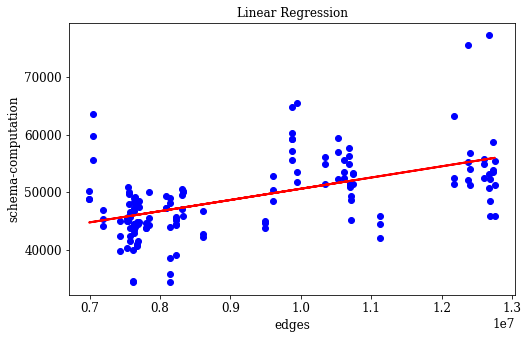

In [98]:
scatter_plot_regression(full_frame, 'edges', 'schema-computation')

Is there a linear correlation between 'vertices' and 'vertexHashIndex'?
Pearson Coefficient of 0.835 (p = 0.000000)
(144, 1)
(144,)
Linear Regression Coefficient of 26.613


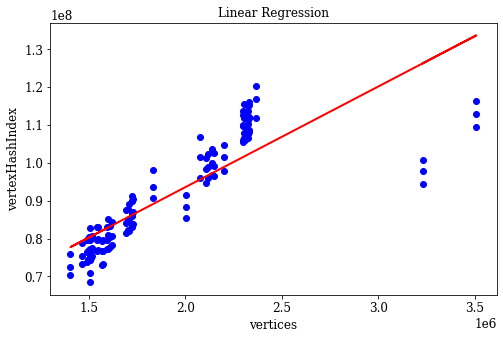

In [99]:
scatter_plot_regression(full_frame, 'vertices', 'vertexHashIndex')

Is there a linear correlation between 'edges' and 'vertexHashIndex'?
Pearson Coefficient of 0.755 (p = 0.000000)
(144, 1)
(144,)
Linear Regression Coefficient of 5.749


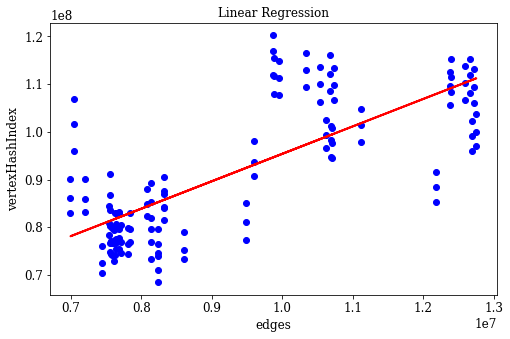

In [100]:
scatter_plot_regression(full_frame, 'edges', 'vertexHashIndex')

# OLD STUFF

In [ ]:
x_values = ['edges'] #'change-ratio'
y_value = ['schema-computation']


x_values = ['vertices'] #'change-ratio'
y_value = ['vertexHashIndex']

#x_values = ['edges'] #'change-ratio'
#y_value = ['vertexHashIndex']

X = full_frame[x_values].values # , 'change-ratio'
y = full_frame[y_value].values

#display(X)

lin = LinearRegression() 
a = [v[0] for v in X]
#b = [v[1] for v in X]
#display(a)
lin.fit(X, y) 
display(lin.coef_)
# Visualising the Linear Regression results 
plt.scatter(a, y, color = 'blue') 
#plt.scatter(b, y, color = 'green') 

plt.plot(X, lin.predict(X), color = 'red') 
plt.title('Linear Regression') 
plt.xlabel(x_values) 
plt.ylabel(y_value) 

plt.show() 
lin.score(X, y)


In [ ]:
change_frame = pd.DataFrame(columns=['SE-ADD', 'SE-DEL','SE-MOD', 'SE-unchanged', 
                                     'instances', 'stability-ratio', 'change-ratio', 
                                     'update-ratio'])
iterations = 0

for collection in collections:
    with open(os.path.join(data_dir, appname + '_'+collection+suffix+'-changes.csv'), 'r') as f:
        df = pd.read_csv(f, sep=',')
        
        iterations = max(iterations, len(df))
        f2 = open(os.path.join(data_dir, appname + '_'+collection+suffix+'-update-time-and-space.csv'), 'r')
        df2 = pd.read_csv(f2, sep=',')
        df2.head()
        
        df2['Imprint links add-del'] = (df2['Imprint links'] - df2['Imprint links'].shift(1,fill_value=0)).abs()

        
        del df['TotalNumberOfNewInstances'] 
        del df['InstanceAddedWithKnownSchema (PE_add)']
        del df['InstancesDeleted (PE_del)']
        del df['ChangedSchemaStructuresBecauseOfNeighbor'] 
        del df['PayloadEntriesAdded'] 
        del df['PayloadEntriesRemoved'] 
        del df['InstanceToSchemaLinksAdded'] 
        del df['InstanceToSchemaLinksRemoved'] 
        del df['TotalNumberOfChangedPayloadElements (real PE_mod)']
        del df['TotalNumberOfSchemaElementsWritten']

        del df['TotalNumberOfSchemaElementsDeleted']
        df = df.set_index('Iteration')
        
        df.columns = ['SE-ADD', 'SE-DEL','SE-MOD', 'SE-unchanged']
        df['instances'] = df2['Imprint links']
        df['stability-ratio'] = df['SE-unchanged'] / df['instances']
        df['add_del-ratio'] = (df['instances'] - df['SE-MOD'] - df['SE-unchanged'] ) / df['instances']

        
        change_frame.loc[collection+':min'] = df.min()
        change_frame.loc[collection+':max'] = df.max()
        change_frame.loc[collection+':mean'] = df.mean()
        change_frame.loc[collection+':std'] = df.std()
        

change_frame.to_csv(out_dir + '/' + appname + '-stats-changes.csv', sep=',', encoding='utf-8')
display(change_frame)

In [ ]:
performance_frame = pd.DataFrame(columns=['Load Graph', 'Parse Graph', 'Partition Graph', 'Schema Computation',
       'Updates', 'Total', 'Batch', 'Seepdup'])

for collection in collections:
    with open(os.path.join(data_dir, appname + '_'+collection+suffix+'-performance.csv'), 'r') as f:
        df = pd.read_csv(f, sep=',')
        df.head()

        df = df.set_index('Iteration')
        print(collection)
#         del df['Load Graph']
#         del df['Parse Graph']
#         del df['Partition Graph']
#         del df['Schema Computation']
#         del df['Updates']
#        df.columns = [collection + '-Inc', collection + '-Batch']    
        convert = lambda x: x / 1000 / 60
        df = df.applymap(convert)  
        df['Seepdup'] = df.Batch / df.Total
        display(df)
        performance_frame.loc[collection+':min'] = df.min()
        performance_frame.loc[collection+':max'] = df.max()
        performance_frame.loc[collection+':mean'] = df.mean()
        performance_frame.loc[collection+':std'] = df.std()
display(performance_frame)
performance_frame.to_csv(out_dir + '/' + appname + '-stats-performance.csv', sep=',', encoding='utf-8')

    
    
# df = pd.concat(frames, sort=False)
# df.columns = ['SchemEX:Incr', 'SchemEX:Batch', 
#              'AttrColl:Incr', 'AttrColl:Batch',
#              'TypeColl:Incr', 'TypeColl:Batch']
# print(df)
    


In [ ]:
curr_dir = join(data_dir, data_size_dir)
onlyfiles = [f for f in listdir(curr_dir) if isfile(join(curr_dir, f)) and f.endswith(".txt")]
onlyfiles = sorted(onlyfiles)

edgecounts = {}
tmp = 0
for filename in onlyfiles:
    # first line: number of types in dataset (not unique)
    # second line: number of edges in dataset (not unique)
    f = open(join(curr_dir,filename), 'r')
    content = f.read().split('\n')
    if len(content) > 2:
        edges = int(content[1])
    else:
        edges = int(content[0])
    if 'iteration' in filename:
        iteration = filename.replace('iteration', '')
        iteration = iteration.replace('-', '')
        iteration = iteration.replace('.txt', '')
        iteration = iteration.replace('.gz', '')
        iteration = iteration.replace('.nq', '')
        iteration = iteration.replace('.nt', '')
               
        edgecounts[int(iteration)] = edges
    else:
        edgecounts[tmp] = edges
        tmp = tmp + 1
        
edgeframe = pd.DataFrame.from_dict(edgecounts, orient='index')
edgeframe = pd.DataFrame.sort_index(edgeframe)
#display(edgeframe)


In [ ]:
size_frame = pd.DataFrame(columns= ['SE links', 'Imprint links', 'Schema Elements (SE)',
       'Schema Relations (SR)', 'summarization-ratio'])

for collection in collections:
    with open(os.path.join(data_dir, appname + '_'+collection+suffix+'-update-time-and-space.csv'), 'r') as f:
        df = pd.read_csv(f, sep=',')
        df.head()

        del df['SecondaryIndex Read time (ms)']
        del df['SecondaryIndex Write time (ms)']
        del df['SecondaryIndex Del time (ms)']
        #--->
        del df['SecondaryIndex Total time (ms)']
        #<----
        # number of primary vertices
        #del df['SE links']
#         if not size_frame.empty:
#             del df['Imprint links']
        del df['Checksum links']
        #del df['Schema Elements (SE)']
        #del df['Schema Relations (SR)']

        del df['SG Read time (ms)']
        del df['SG Write time (ms)']
        del df['SG Del time (ms)']

        del df['Sec. Index Size (bytes)']
        del df['Index Size (bytes)']
        del df['Graph Size (bytes)']
        #print(df)
        df = df.set_index('Iteration')
        print(df.columns)
        size_frame.loc[collection+':min'] = df.min()
        size_frame.loc[collection+':max'] = df.max()
        size_frame.loc[collection+':mean'] = df.mean()
        size_frame.loc[collection+':std'] = df.std()
        size_frame['summarization-ratio'] = size_frame['Imprint links'] / size_frame['SE links']
        


display(size_frame)
size_frame.to_csv(out_dir + '/' + appname + '-stats-size.csv', sep=',', encoding='utf-8')

In [ ]:
correlation_frame = pd.DataFrame()
data_dir = "test"
collections = ['schemex', 'type', 'attribute']#,] #, 'type', 'attribute'] # 'type' 'attribute' 
#collections = ['schemex']

appnames = ["LUBM","BSBM","dyldo_y2019_core"] # "dyldo_y2019_full", #"LUBM", "BSBM"
#appnames = ["BSBM"]#, "LUBM", "BSBM"] # "dyldo_y2019_full", #"LUBM", "BSBM"

suffix = ''
for appname in appnames:
    for collection in collections:
        with open(os.path.join(data_dir, appname + '_'+collection+suffix+'-performance.csv'), 'r') as f:
            
            df = pd.read_csv(f, sep=',')
            display(df.head())
            temp_frame = pd.DataFrame()
            #temp_frame['Iteration'] = df['Iteration']
            #df = df.set_index('Iteration')

            #temp_frame = temp_frame.set_index('Iteration')

            temp_frame['schema-computation'] = df['Schema Computation']
            temp_frame['performance'] = df.Total
            #temp_frame['speed-up'] = df.Batch / df.Total
            temp_frame['updates'] = df['Updates']
            f2 = open(os.path.join(data_dir, appname + '_'+collection+suffix+'-changes.csv'), 'r')
            df2 = pd.read_csv(f2, sep=',')
            #df2 = df2.set_index('Iteration')

            display(df2)


            f3 = open(os.path.join(data_dir, appname + '_'+collection+suffix+'-update-time-and-space.csv'), 'r')
            df3 = pd.read_csv(f3, sep=',')
            df3 = df3.set_index('Iteration')
            temp_frame['size'] = df3['Imprint links']
            df['instances'] = df3['Imprint links']
            df['SE-unchanged'] = df2['InstanceNotChanged (PE_mod)']

            #display(df)
            #display(degree_frame['max_degree'])
            temp_frame['max-degree'] = degree_frame['max_degree']
            temp_frame['avg-degree'] = degree_frame['avg_degree']

            temp_frame['change-ratio'] = ((df3['Imprint links'] - df2['InstanceNotChanged (PE_mod)']) / df3['Imprint links'])
            temp_frame['update-ratio'] = (df2['NewlyObservedSchema (SE_new)'] + df2['DeletedSchemaStructures (SE_del)']) / df3['Schema Elements (SE)']
            temp_frame['total-changes'] = (df3['Imprint links'] - df2['InstanceNotChanged (PE_mod)'])
            temp_frame['total-updates'] = (df2['NewlyObservedSchema (SE_new)'] + df2['DeletedSchemaStructures (SE_del)'])
            temp_frame['summary-size'] = df3['Schema Elements (SE)']
#             temp_frame['change-ratio'] = 1 - (df2['InstanceNotChanged (PE_mod)'] / df3['Imprint links'].shift(1))
            temp_frame['summarization-ratio'] =  df3['Imprint links']/ df3['SE links'].shift(1)
#             temp_frame['summary-mod-ratio'] = (df2['TotalNumberOfSchemaElementsWritten'] + df2['TotalNumberOfSchemaElementsDeleted']) /(1 * df3['Schema Elements (SE)'].shift(1)
#)# 
            # test new summary graphs
            temp_frame['summary-adds'] = df2['NewlyObservedSchema (SE_new)']
            
            temp_frame['add-vs-updates'] = df2['NewlyObservedSchema (SE_new)'] / df2['TotalNumberOfSchemaElementsWritten']
            temp_frame['del-vs-update'] = df2['DeletedSchemaStructures (SE_del)'] / df2['TotalNumberOfSchemaElementsDeleted']
            
            #display(temp_frame)
            if correlation_frame.empty:
                correlation_frame = temp_frame.iloc[1:]
            else:
                correlation_frame = correlation_frame.append(temp_frame.iloc[1:])

                

correlation_frame['combined'] = correlation_frame['size'] * correlation_frame['summarization-ratio']            

#display(degree_frame)
#correlation_frame['ssss'] = degree_frame['avg_degree']
correlation_frame['add-time'] = correlation_frame['summary-adds'] / correlation_frame['updates']            

display(correlation_frame)

print(correlation_frame['add-time'].mean())

In [ ]:
correlation_frame

In [ ]:
print('ms per addition')
print(correlation_frame['add-time'].mean())
print(correlation_frame['add-time'].std())

In [ ]:
x_values = ['size'] #'change-ratio'
y_value = ['schema-computation']
X = correlation_frame[x_values].values # , 'change-ratio'
y = correlation_frame[y_value].values

#display(X)

lin = LinearRegression() 
a = [v[0] for v in X]
#b = [v[1] for v in X]
#display(a)
lin.fit(X, y) 
display(lin.coef_)
# Visualising the Linear Regression results 
plt.scatter(a, y, color = 'blue') 
#plt.scatter(b, y, color = 'green') 

plt.plot(X, lin.predict(X), color = 'red') 
plt.title('Linear Regression') 
plt.xlabel(x_values) 
plt.ylabel(y_value) 

plt.show() 
lin.score(X, y)

In [ ]:
# Total berechnung hängt vom Datensatz ab, nicht nur von der Größe (param = 1)
# Change ratio nicht unbedingt


In [ ]:
X = correlation_frame.iloc[:, 4:5].values 
y = correlation_frame.iloc[:, 0].values 
lin = LinearRegression() 

lin.fit(X, y) 
# Visualising the Linear Regression results 
plt.scatter(X, y, color = 'blue') 

plt.plot(X, lin.predict(X), color = 'red') 
plt.title('Linear Regression') 
plt.xlabel(correlation_frame.columns[4]) 
plt.ylabel(correlation_frame.columns[0]) 

plt.show() 

In [ ]:
X = correlation_frame.iloc[:, 3:4].values 
y = correlation_frame.iloc[:, 0].values 
lin = LinearRegression() 

lin.fit(X, y) 
# Visualising the Linear Regression results 
plt.scatter(X, y, color = 'blue') 

plt.plot(X, lin.predict(X), color = 'red') 
plt.title('Linear Regression') 
plt.xlabel('Combined-factor ratio') 
plt.ylabel('Speed-up') 


plt.show() 